In [69]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score, confusion_matrix, recall_score
from sklearn.manifold import TSNE
import seaborn as sns
import re
import matplotlib.pyplot as plt

### Data Preparation

In [6]:
# read Cell classes
series_txt = 'GSE84465_series_matrix.txt'
with open(series_txt, "r") as series:
    for line in series:
        if re.match("^!Sample_characteristics_ch1\s+\"tissue:", line):
            cell_class = line.rstrip()
            cell_class = re.split('"\t"tissue: |!Sample_characteristics_ch1\t"tissue: |"', cell_class)[1:-1]
        elif re.match("^!Sample_description\t\"\d+", line):
            cell_id = line.rstrip()
            cell_id = re.split('"\t"|!Sample_description\t"|"', cell_id)[1:-1]
series.close()

# Create a Y dataframe
id_class = list(zip(cell_id, cell_class))
Y = pd.DataFrame(id_class, columns=['Cell ID','Cell class'])
Y

,Cell ID,Cell class
0,1001000173.G8,Tumor
1,1001000173.D4,Tumor
2,1001000173.B4,Tumor
3,1001000173.A2,Tumor
4,1001000173.E2,Tumor
...,...,...
3584,1001000271.F1,Tumor
3585,1001000271.D4,Tumor
3586,1001000271.C1,Tumor
3587,1001000271.H7,Tumor


In [7]:
df_complete = pd.read_csv('GSE84465_GBM_All_data.csv', delimiter=' ')
df_complete

,1001000173.G8,1001000173.D4,1001000173.B4,1001000173.A2,1001000173.E2,1001000173.F6,1001000173.B12,1001000173.D6,1001000173.H1,1001000173.E4,...,1001000271.C2,1001000271.D1,1001000271.B1,1001000271.A3,1001000271.E1,1001000271.F1,1001000271.D4,1001000271.C1,1001000271.H7,1001000271.H2
1/2-SBSRNA4,1,0,0,0,0,0,0,64,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,53,0,0,229,...,7,2,0,0,0,0,61,0,0,0
A1BG-AS1,0,0,0,1,0,0,24,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2LD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
no_feature,429554,73969,185910,355266,536444,476308,185700,373777,344667,273108,...,331208,48936,290280,476066,150601,223514,173101,349266,3117,391230
ambiguous,8372,2297,12481,11386,8969,6008,14784,11346,8228,13076,...,5791,1022,4994,7266,6384,3400,3605,8243,34,6004
too_low_aQual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
not_aligned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# make samples as rows
df_complete = df_complete.T
df_complete

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR,no_feature,ambiguous,too_low_aQual,not_aligned,alignment_not_unique
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,429554,8372,0,0,111288
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,73969,2297,0,0,19969
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,0,834,0,0,0,185910,12481,0,0,132812
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,0,0,33,1,0,355266,11386,0,0,131212
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,536444,8969,0,0,145595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,223514,3400,0,0,108873
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,0,0,173101,3605,0,0,64761
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,0,18,0,64,0,349266,8243,0,0,114882
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3117,34,0,0,507


In [9]:
# append "Labels" column
df_complete["Labels"] = cell_class
df_complete

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZYX,ZZEF1,ZZZ3,tAKR,no_feature,ambiguous,too_low_aQual,not_aligned,alignment_not_unique,Labels
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,429554,8372,0,0,111288,Tumor
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,73969,2297,0,0,19969,Tumor
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,834,0,0,0,185910,12481,0,0,132812,Tumor
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,0,33,1,0,355266,11386,0,0,131212,Tumor
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,536444,8969,0,0,145595,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,223514,3400,0,0,108873,Tumor
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,0,173101,3605,0,0,64761,Tumor
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,18,0,64,0,349266,8243,0,0,114882,Tumor
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3117,34,0,0,507,Tumor


In [10]:
# remove the last 6 columns 
df = df_complete.iloc[: , :-6]
df

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
1001000173.G8,1,0,0,0,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0,0,0
1001000173.D4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000173.B4,0,0,0,0,0,0,0,0,0,0,...,0,0,40,33,0,0,834,0,0,0
1001000173.A2,0,0,1,0,0,0,34,0,0,0,...,0,0,41,61,0,0,0,33,1,0
1001000173.E2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,439,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001000271.F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.D4,0,61,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001000271.C1,0,0,0,0,0,61,0,0,2,0,...,0,1,98,19,0,0,18,0,64,0
1001000271.H7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# remove columns and rows that have sum = 0 -> no information/expression
df.replace(np.nan,0)
df = df.loc[(df.sum(axis=1) != 0), (df.sum(axis=0) != 0)]

In [12]:
# Data normilizations
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)
scaled_df

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
0,-0.029619,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,1.424694,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795
1,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795
2,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,0.580251,0.006859,-0.044885,-0.197845,4.037062,-0.233546,-0.212233,-0.038795
3,-0.070584,-0.240253,0.068737,-0.026742,-0.09132,-0.482904,1.517742,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,0.598911,0.284695,-0.044885,-0.197845,-0.519129,0.120454,-0.198902,-0.038795
4,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,-0.166165,4.035477,-0.044885,-0.197845,-0.519129,-0.222819,-0.212233,-0.038795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795
3585,-0.070584,2.219683,-0.094747,-0.026742,-0.09132,-0.481361,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795
3586,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.435850,-0.095393,-0.049328,0.288078,-0.035642,...,-0.175459,-0.052102,1.662554,-0.132059,-0.044885,-0.197845,-0.420794,-0.233546,0.640947,-0.038795
3587,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.175459,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795


In [13]:
labels = Y['Cell class']
labels = labels.replace('Tumor', 1)
labels = labels.replace('Periphery', 0)
scaled_df = scaled_df.assign(target=labels.values)
scaled_df

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR,target
0,-0.029619,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,1.424694,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795,1
1,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795,1
2,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,0.580251,0.006859,-0.044885,-0.197845,4.037062,-0.233546,-0.212233,-0.038795,1
3,-0.070584,-0.240253,0.068737,-0.026742,-0.09132,-0.482904,1.517742,-0.049328,-0.038438,-0.035642,...,-0.103026,0.598911,0.284695,-0.044885,-0.197845,-0.519129,0.120454,-0.198902,-0.038795,1
4,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,-0.166165,4.035477,-0.044885,-0.197845,-0.519129,-0.222819,-0.212233,-0.038795,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795,1
3585,-0.070584,2.219683,-0.094747,-0.026742,-0.09132,-0.481361,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795,1
3586,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.435850,-0.095393,-0.049328,0.288078,-0.035642,...,-0.052102,1.662554,-0.132059,-0.044885,-0.197845,-0.420794,-0.233546,0.640947,-0.038795,1
3587,-0.070584,-0.240253,-0.094747,-0.026742,-0.09132,-0.482904,-0.095393,-0.049328,-0.038438,-0.035642,...,-0.103026,-0.166165,-0.320590,-0.044885,-0.197845,-0.519129,-0.233546,-0.212233,-0.038795,1


### mRMR Feature Selection -> Implemented in R

### SVM Construction

In [14]:
mrmr_features = pd.read_csv('mrmr_features.txt', sep=" ")
mrmr_features

,Name,Score
0,RPL41,0.070834
1,HTRA1,0.048802
2,CCL3,0.042464
3,VIM,0.031755
4,MTSS1,0.025442
...,...,...
95,PDE3B,0.011782
96,UBA52,0.012008
97,CDK4,0.011786
98,FAIM2,0.011900


In [50]:
svms = {}
math_cor_coef = {}
accuracy= {}
y_true_dict = {}
y_pred_dict = {}
genes = []

for index, row in mrmr_features.iterrows():
  genes.append(row["Name"])
  if index == 71:

    # apply incremental feature selection (IFS)
    X = scaled_df[genes]

    # apply LOOCV
    loo = LeaveOneOut()

    y_true_arr = []
    y_pred_arr = []
    for train_index, test_index in loo.split(X):
      X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
      y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
      
      # train SVM
      svms[index] = SVC()
      svms[index].fit(X_train, y_train)
      
      # predict gene
      y_pred = svms[index].predict(X_test)
      y_pred_arr.append(y_pred[0])
      y_true_arr.append(y_test.values[0])

    y_true_dict[index] = y_true_arr
    y_pred_dict[index] = y_pred_arr
    accuracy[index] = accuracy_score(y_true_arr, y_pred_arr)
    math_cor_coef[index] = matthews_corrcoef(y_true_arr, y_pred_arr)
    print("Mathew cor_coef for " + str(index + 1) + " genes is: " + str(math_cor_coef[index]) + " and accuracy: " + str(accuracy[index]))

Mathew cor_coef for 72 genes is: 0.8235674100154773 and accuracy: 0.9205906937865701


In [51]:
confusion = confusion_matrix(y_true_dict[71], y_pred_dict[71])
confusion.ravel()
# [True Negatives (TN), False Positives (FP), False Negatives (FN), True Positives (TP)]

array([1079,  167,  118, 2225])

In [52]:
recall_sensitivity = recall_score(y_true_dict[71], y_pred_dict[71], pos_label=1)
recall_specificity = recall_score(y_true_dict[71], y_pred_dict[71], pos_label=0)
recall_sensitivity, recall_specificity

(0.949637217242851, 0.8659711075441413)

In [17]:
cor_acc = pd.read_csv('svm_math_cor.txt', delimiter=",", header=None, names=['Genes', "Cor", "Accuracy"])
corr = cor_acc[['Cor']].to_numpy()
num_genes = cor_acc[['Genes']].to_numpy()
acc = cor_acc[['Accuracy']].to_numpy()

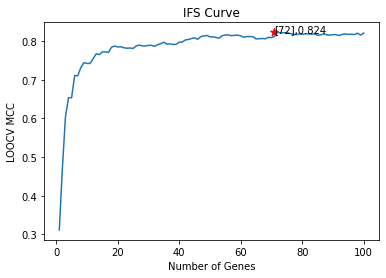

In [48]:
plt.plot(num_genes, corr)
plt.scatter(np.where(cor_acc["Cor"] == np.amax(cor_acc["Cor"]))[0], np.amax(cor_acc["Cor"]), s=70, marker='*', c='red')
plt.annotate(str(np.where(cor_acc["Cor"] == np.amax(cor_acc["Cor"]))[0] + 1) + ',' + str(round(np.amax(cor_acc["Cor"]), 3)), (np.where(cor_acc["Cor"] == np.amax(cor_acc["Cor"]))[0], np.amax(cor_acc["Cor"])))
plt.xlabel("Number of Genes")
plt.ylabel("LOOCV MCC")
plt.title("IFS Curve")
plt.show()

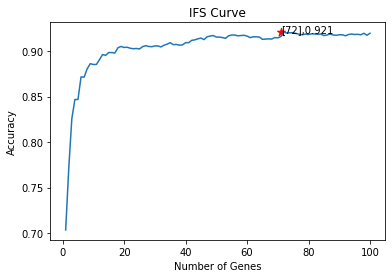

In [49]:
plt.plot(num_genes, acc)
plt.scatter(np.where(cor_acc["Accuracy"] == np.amax(cor_acc["Accuracy"]))[0], np.amax(cor_acc["Accuracy"]), s=70, marker='*', c='red')
plt.annotate(str(np.where(cor_acc["Accuracy"] == np.amax(cor_acc["Accuracy"]))[0] + 1) + ',' + str(round(np.amax(cor_acc["Accuracy"]), 3)), (np.where(cor_acc["Accuracy"] == np.amax(cor_acc["Accuracy"]))[0], np.amax(cor_acc["Accuracy"])))
plt.xlabel("Number of Genes")
plt.ylabel("Accuracy")
plt.title("IFS Curve")
plt.show()

In [72]:
# find and store FP, FN, TN, TP indexes
fp_rows = []
fn_rows = []
tn_rows = []
tp_rows = []

for i in range(len(y_pred_dict[71])):
  if y_pred_dict[71][i] == 1 and y_true_dict[71][i] == 0:
    fp_rows.append(i)
  elif y_pred_dict[71][i] == 1 and y_true_dict[71][i] == 1:
    tp_rows.append(i)
  elif y_pred_dict[71][i] == 0 and y_true_dict[71][i] == 0:
    tn_rows.append(i)
  else:
    fn_rows.append(i)

In [76]:
labels = Y['Cell class']
labels = labels.replace('Tumor', 'Actual GBM')
labels = labels.replace('Periphery', 'Actual non-GBM')
X_with_labels = X.assign(target=labels.values)

In [77]:
positive_rows = np.concatenate((np.array(tp_rows), np.array(fp_rows)), axis=0)
positive_samples = X_with_labels.iloc[positive_rows]

negative_rows = np.concatenate((np.array(fn_rows), np.array(tn_rows)), axis=0)
negative_samples = X_with_labels.iloc[negative_rows]

/home/dparanou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dparanou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Predicted GBM Cells')]

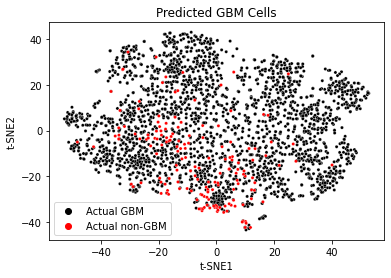

In [85]:
X_tsne = TSNE(n_components=2, random_state=0).fit_transform(positive_samples.iloc[: , :-1]) 

df_tsne = pd.DataFrame()
df_tsne["y"] = positive_samples['target']
df_tsne["t-SNE1"] = X_tsne[:,0]
df_tsne["t-SNE2"] = X_tsne[:,1]

sns.scatterplot(x="t-SNE1", y="t-SNE2", hue=df_tsne.y.tolist(),
                palette=['black', 'red'],
                data=df_tsne, s=10).set(title="Predicted GBM Cells")

/home/dparanou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dparanou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Predicted non-GBM Cells')]

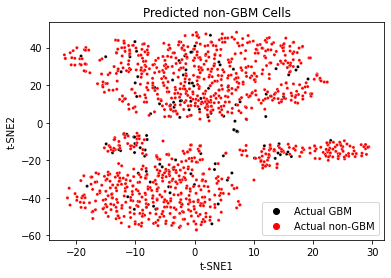

In [86]:
X_tsne = TSNE(n_components=2, random_state=0).fit_transform(negative_samples.iloc[: , :-1]) 

df_tsne = pd.DataFrame()
df_tsne["y"] = negative_samples['target']
df_tsne["t-SNE1"] = X_tsne[:,0]
df_tsne["t-SNE2"] = X_tsne[:,1]

sns.scatterplot(x="t-SNE1", y="t-SNE2", hue=df_tsne.y.tolist(),
                palette=['black', 'red'],
                data=df_tsne, s=10).set(title="Predicted non-GBM Cells")